### Getting Ready

We'll start by importing the packages we need.  In addition to the diffusers library, we'll load two new modules from Hugging Face.
- [datasets](https://huggingface.co/docs/datasets/index) gives access to data sets stored on [Hugging Face Hub](https://huggingface.co/datasets).
- [huggingface_hub](https://huggingface.co/docs/huggingface_hub/index) is a Python client to the Hugging Face Hub API.

In [1]:
import os
import sys

import datasets
import diffusers
import huggingface_hub
import requests
import torch
from dotenv import load_dotenv
from huggingface_hub import HfApi
from IPython.display import display

We'll print out version number of the critical packages, to help with future reproducibility.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("datasets version: ", datasets.__version__)
print("diffusers version: ", diffusers.__version__)
print("huggingface_hub version: ", huggingface_hub.__version__)
print("torch version:", torch.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
datasets version:  3.3.2
diffusers version:  0.32.2
huggingface_hub version:  0.29.3
torch version: 2.2.2+cu121


Let's check if a GPU is available.  If not, this notebook will take a long time to run!

In [3]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"Using {device} device with {dtype} data type.")

Using cuda device with torch.float16 data type.


### Load Stable Diffusion

We'll start by loading in the same Stable Diffusion pipeline we used in the previous lesson.  We could use the `StableDiffusionPipeline` as before, if we wanted.  But the diffusers library has a handy `AutoPipelineForText2Image` class, which will figure out the right pipeline to use based on the model it's given.

**Task 6.3.1:** Load the Stable Diffusion v1.4 pipeline.

In [4]:
MODEL_NAME = "CompVis/stable-diffusion-v1-4"

pipeline = diffusers.StableDiffusionPipeline.from_pretrained(
    MODEL_NAME, torch_dtype=dtype
)
pipeline.to(device)

print(type(pipeline))

Couldn't connect to the Hub: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /api/models/CompVis/stable-diffusion-v1-4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7b0d5a1b5690>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 1017547f-5c94-409d-b9d6-931cf0e36126)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'>


Our goal is to use this to generate images of our dog Maya.  Here's a picture:

![Maya](images/maya.jpg)

Does Stable Diffusion already know what she looks like?

**Task 6.3.2:** Generate four images with the prompt, "My dog Maya."

In [6]:
images = pipeline(["My dog Maya."] * 4)

for im in images:
    display(im)

  0%|          | 0/50 [00:00<?, ?it/s]

'images'

'nsfw_content_detected'

### Load Data Set for Fine Tuning

While Stable Diffusion can produce many cute looking dogs, it obviously doesn't know what Maya looks like.  And that's expected&mdash;clearly the model can't know what every dog in the entire world looks like!

We can fix that by fine-tuning the model on pictures of Maya.  To do this, we'll need a data set with pictures of Maya.  Luckily for us, this [data set already exists](https://huggingface.co/datasets/worldquant-university/maya-dataset-v1) on Hugging Face Hub!

Data sets on Hugging Face Hub are identified as `user/dataset`.

**Task 6.3.3:** Create a data set builder, which will let us access metadata about this data set.

In [7]:
DATASET_NAME = "worldquant-university/maya-dataset-v1"
data_builder = datasets.load_dataset_builder(DATASET_NAME)

print(data_builder.dataset_name)

Using the latest cached version of the dataset since worldquant-university/maya-dataset-v1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/worldquant-university___maya-dataset-v1/default/0.0.0/92df4e98c02b510a16fd37871aa74e80b5bb39d1 (last modified on Thu Mar 27 11:09:03 2025).


maya-dataset-v1


This builder object has downloaded metadata about the data set.  This allows us to see what features are available, for example.

In [8]:
print(data_builder.info.features)

{'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None)}


**Task 6.3.4:** Determine which splits are included.  There is a `.splits` attribute in the `.info` property of our builder.

In [9]:
print(data_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=4324, num_examples=26, shard_lengths=None, dataset_name='maya-dataset-v1')}


This builder didn't download all of the data.  This is nice in general, since many data sets can be very large.  We can see above that there are only 26 rows in this dataset, so we can afford to download the whole thing.

**Task 6.3.5:** Load the Maya data set from Hugging Face Hub.

In [10]:
data = datasets.load_dataset(DATASET_NAME)

print(data)

Using the latest cached version of the dataset since worldquant-university/maya-dataset-v1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/worldquant-university___maya-dataset-v1/default/0.0.0/92df4e98c02b510a16fd37871aa74e80b5bb39d1 (last modified on Thu Mar 27 11:09:03 2025).


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 26
    })
})


This `DatasetDict` acts like a dictionary.  We can use key indexing to find the data itself.

In [11]:
data["train"]["image"]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x1600>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1536x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1536x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RG

**Task 6.3.6:** Display the fourth image. (Or take a look at more of them, if you like!)

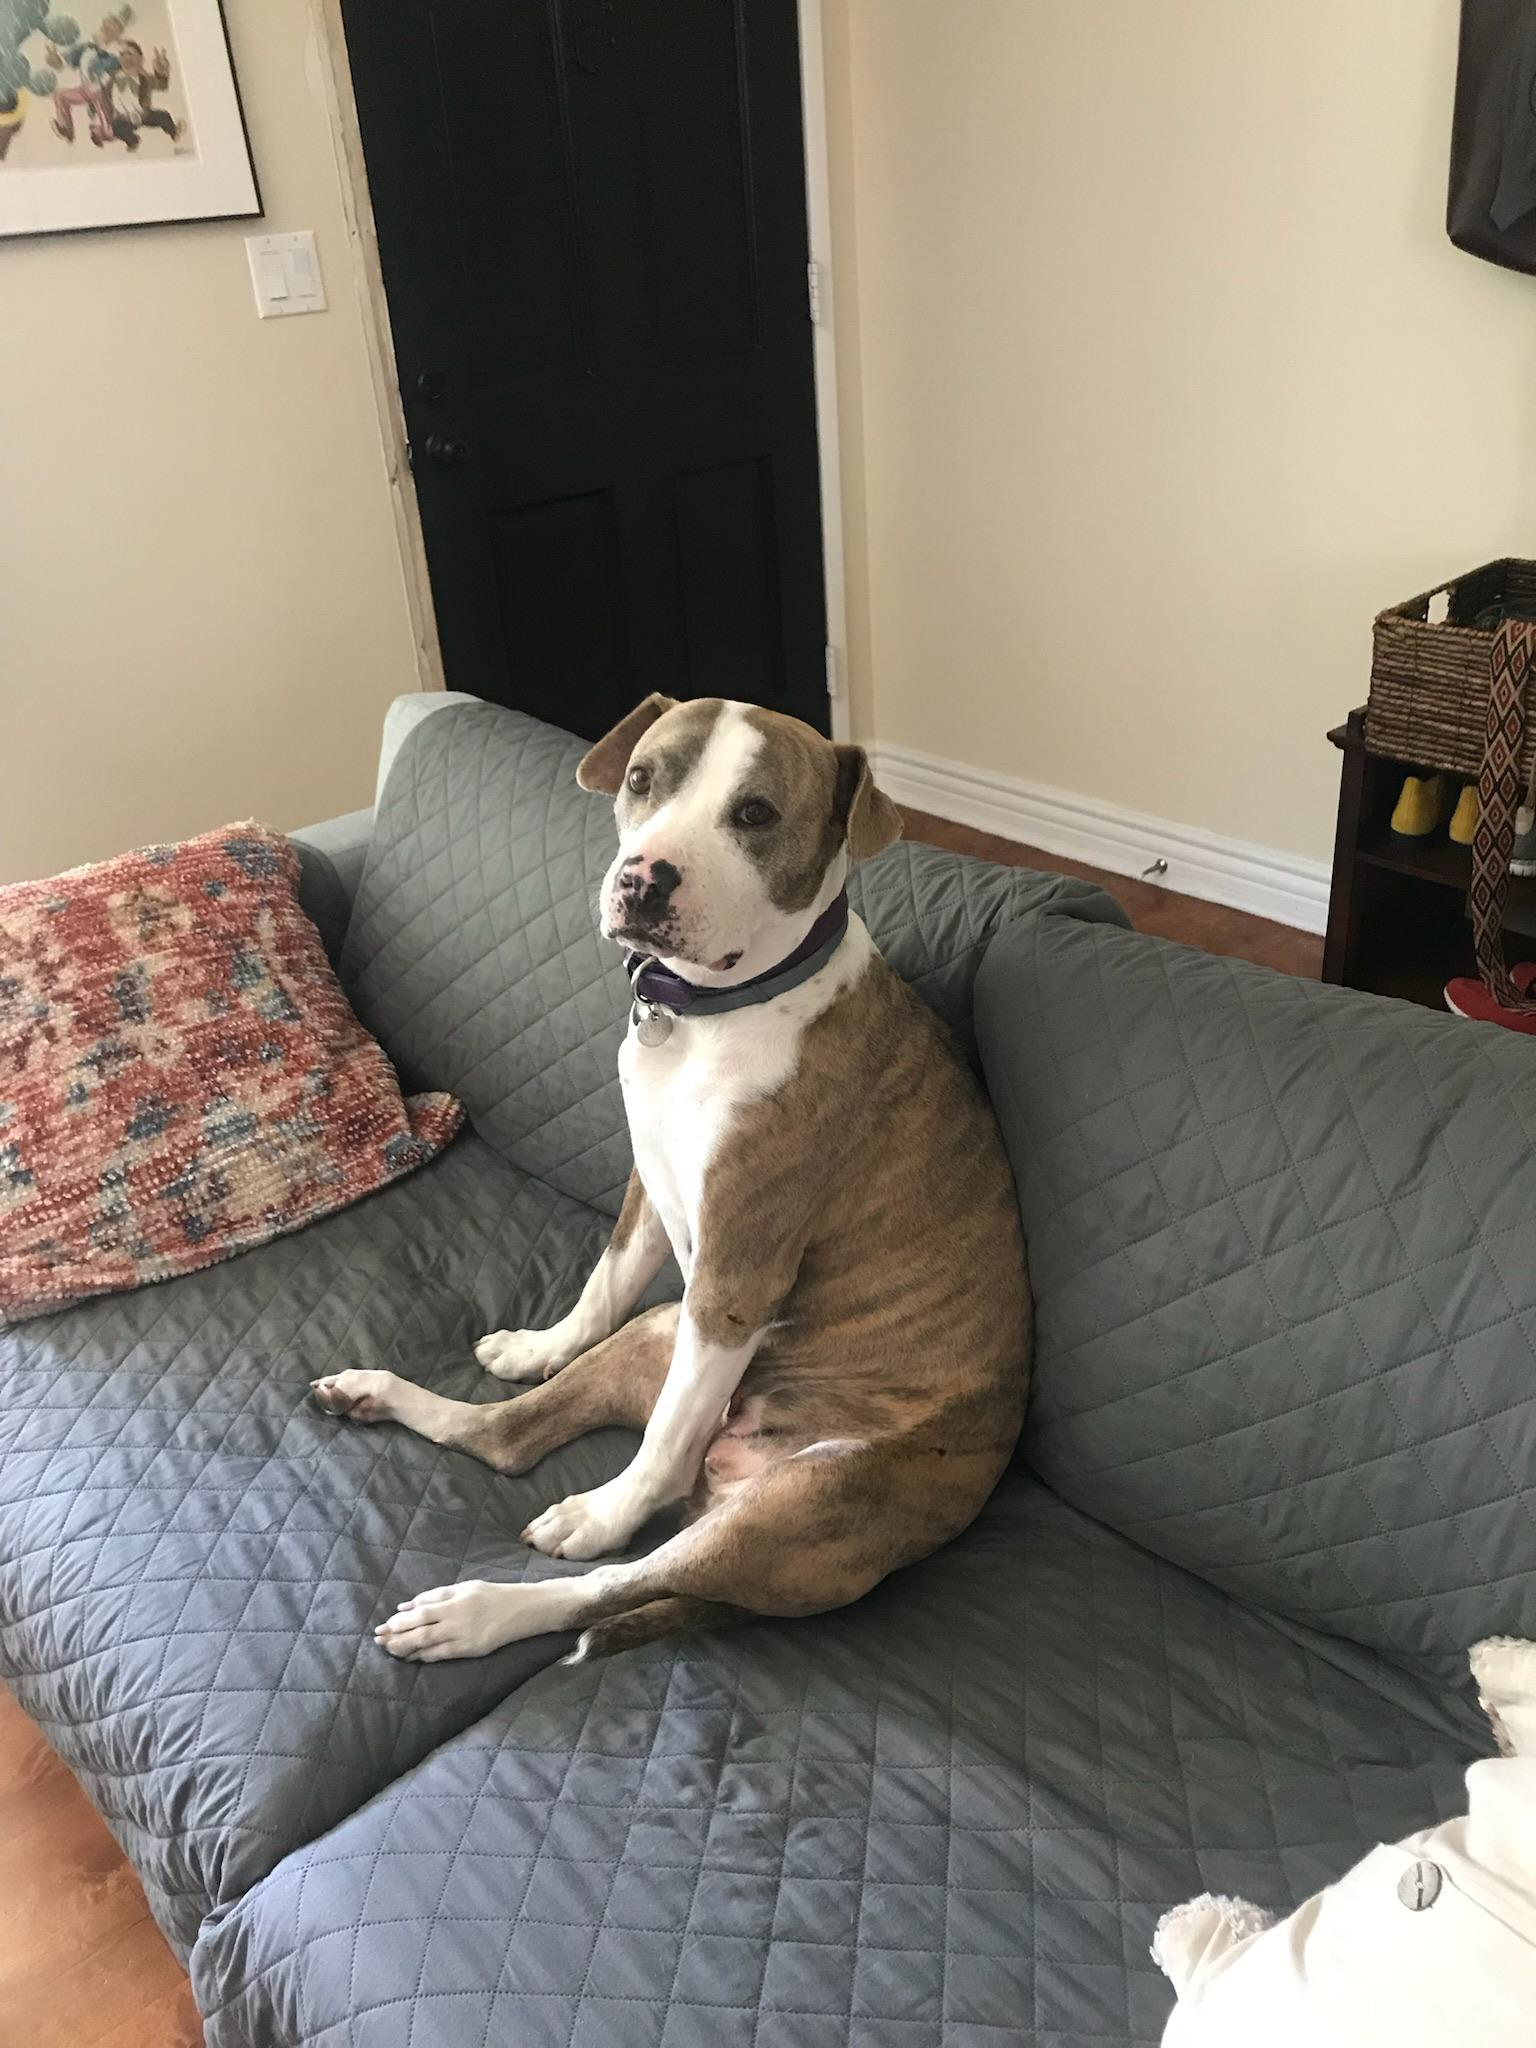

In [12]:
# The values are PIL images, so they will be displayed
# automatically by Jupyter.
data["train"]["image"][3]

**Task 6.3.7:** Print out the text associated with each row in the training data.

In [13]:
# Use dictionary indexing to look up the text values.
data["train"]["text"]

['my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya']

If the fine-tuning works, the model should figure out what "My dog Maya" looks like.

### LoRA Fine-tuning

We have the model and we have the data, so we're ready to do the LoRA fine-tuning.  The actual process is rather involved.  Luckily, we don't have to program it ourselves.  The diffusers project includes [a script](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py) that does LoRA fine-tuning of a Hugging Face model based on a Hugging Face data set.  There's a copy of this script in the same directory as this notebook: [`train_text_to_image_lora.py`](train_text_to_image_lora.py).

In addition to the model and data set names, we'll need to tell the script where to save the LoRA weights.  It's up to you, but we'd recommend `maya_model_v1_lora`.

**Task 6.3.8:** Set the `OUTPUT_DIR` variable with the correct value.

In [14]:
OUTPUT_DIR = "maya_model_v1_lora"

**Task 6.3.9:** Inspect the `train_text_to_image_lora.py` script.

**Due to GPU limitations you CAN NOT run this script.**

It's an advanced (and long) script. But if you want, take a look at it to familiarize yourself with the process of fine tuning.

<div class="alert alert-info" role="alert">
    <p><b>Changes with respect to the video</b></p>
    <p>The instructor in the video is executing the script in the notebook. But due to high GPU usage, we can't replicate it in your interactive environment.</p>
    <p><b>Please, do NOT try running the script as it'll fail and restart your lab environment</b></p>
    <p>Instead, we have already ran the script for you with different training epochs and stored the results in the output directory.</p>
</div>

This command could take an hour to complete.  Once it's done, there should be a `pytorch_lora_weights.safetensors` file in the output directory.

In [15]:
!ls -lah $OUTPUT_DIR

total 22M
drwxr-xr-x 3 root root 4.0K Mar 31 18:29 .
drwxr-xr-x 1 root root 4.0K May 26 17:13 ..
drwxr-xr-x 2 root root 4.0K Mar 31 16:50 .ipynb_checkpoints
-rw-r--r-- 1 root root 3.1M Mar 31 17:18 pytorch_lora_weights.10_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 18:14 pytorch_lora_weights.15_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 16:57 pytorch_lora_weights.1_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 18:29 pytorch_lora_weights.20_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 17:01 pytorch_lora_weights.2_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 17:05 pytorch_lora_weights.3_epochs.safetensors
-rw-r--r-- 1 root root 3.1M Mar 31 17:10 pytorch_lora_weights.5_epochs.safetensors


<div class="alert alert-info" role="alert">
    <p><b>Changes with respect to the video</b></p>
    <p>We have provided MULTIPLE examples of fine tuning with different epochs so you can compare.</p>
</div>

### Load LoRA Weights

Now that we have the LoRA weights, we can load them into the pipeline we already have.  The pipeline has a `.load_lora_weights()` method that can take a directory path as an argument.  The file name of the weights file is given separately in the `weight_name` argument.

**Task 6.3.10:** Load the LoRA weights into our pipeline.

<div class="alert alert-info" role="alert">
    <p><b>Changes with respect to the video</b></p>
    <p>We have picked the weights trained for 10 epochs. You can choose your own. If you're going to choose another one, make sure to invoke:
    <code><pre>pipeline.unload_lora_weights()</pre></code></p>
</div>

In [16]:
pipeline.load_lora_weights(
    OUTPUT_DIR, # Directory containing weights file

    weight_name="pytorch_lora_weights.10_epochs.safetensors",
)

**Task 6.3.11:** Generate four images of "My dog Maya" with the fine-tuned model.

In [18]:
images = pipeline(["My dog maya"] * 4)

for im in images:
    display(im)

  0%|          | 0/50 [00:00<?, ?it/s]

'images'

'nsfw_content_detected'

These should look (a bit) more like Maya!

# Conclusion

You've now used the fine-tuned model to produce images of our dog Maya that look (a bit more) like her.  If we had more training data and had trained for more epochs, perhaps the model would perform even better.  By using the LoRA algorithm, we could do the fine-tuning with only a fraction of the parameters in the original model.  (Note that the file containing the LoRA weights is about 3 MB in size.  The full weights for the Stable Diffusion model are about 3 GB in size!)

In the process, we've learned:
- How to download data sets from Hugging Face.
- How to run LoRA from a script.
- How to load the LoRA weights into a Stable Diffusion pipeline.
- How to set up a Hugging Face token for API access.
- How to upload weights to Hugging Face repository.

In the next lesson, we'll use our fine-tuned model as a component in a Streamlit web app.